In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm

from src.ica import ICA
from src.network import build_graph, get_nodes_static_metrics

# 4 - experiments

This notebook presents experiments of influence of the method and the number of uncovered nodes on the result F1Score (Macro).  

Since there is some randomness in the classifier, experiments for each parameters setup are performed 10 times and mean F1Score is saved.

## Data loading

In [4]:
data = pd.read_csv('./data_interim/processed_data.csv', index_col=0)
data.head()

,Sender,Recipient,EventDate
0,17,37,2010-01-02 17:40:10
1,17,136,2010-01-02 17:40:10
2,17,62,2010-01-02 17:40:10
3,17,129,2010-01-02 17:40:10
4,17,32,2010-01-02 17:40:10


In [5]:
high_ids = [86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163]
mid_ids = [76, 90, 136, 137, 143, 152, 47, 162]
workers_ids = set(np.concatenate([data['Sender'].unique(), data['Recipient'].unique()]))
regular_ids = workers_ids - set(high_ids) - set(mid_ids)

classes = {}
for w in regular_ids:
    classes[w] = 0
for w in mid_ids:
    classes[w] = 1
for w in high_ids:
    classes[w] = 2

data['EventDate'] = pd.to_datetime(data['EventDate'])
data['h'] = data.apply(lambda x: x['EventDate'].hour, axis=1)
G = build_graph(data, 10)
G = G.subgraph(
    sorted(nx.connected_components(G), key=len, reverse=True)[0]
)

## Experiments

In [7]:
df = get_nodes_static_metrics(G)

In [9]:
df.columns

Index(['node', 'degree', 'degree_centrality', 'betweenness_centrality',
       'closeness_centrality', 'pagerank'],
      dtype='object')

In [12]:
np.arange(0.1, 1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [19]:
results = pd.DataFrame(columns=['Method', 'Uncovered_part', 'F1Score'])

for method in tqdm([
    'degree', 'degree_centrality', 'betweenness_centrality',
    'closeness_centrality', 'pagerank'
]):

    for uncovered_part in np.arange(0.1, 1, 0.1):

        scores = []

        for i in range(10):

            labels_register = ICA(
                G, classes,
                method, uncovered_part,
                DecisionTreeClassifier(),
                10, False
            )
            scores.append(
                f1_score(
                    labels_register['real_label'],
                    labels_register['predicted_label'],
                    average='macro'
                )
            )

        results = results.append(
            {
                'Method': method,
                'Uncovered_part': uncovered_part,
                'F1Score': np.mean(np.array(scores))
            },
            ignore_index=True
        )

results.to_csv('./data_interim/experiments_results.csv')

100%|██████████| 5/5 [13:01<00:00, 156.37s/it]


In [20]:
results

,Method,Uncovered_part,F1Score
0,degree,0.1,0.406288
1,degree,0.2,0.443280
2,degree,0.3,0.337123
3,degree,0.4,0.376858
4,degree,0.5,0.393375
5,degree,0.6,0.426654
6,degree,0.7,0.433110
7,degree,0.8,0.462595
8,degree,0.9,0.399859
9,degree_centrality,0.1,0.429397


<AxesSubplot:xlabel='Uncovered_part', ylabel='Method'>

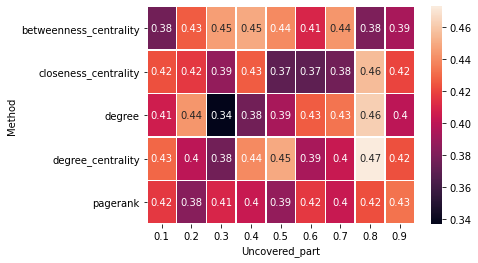

In [31]:
results_p = results.pivot('Method', 'Uncovered_part', 'F1Score')

sns.heatmap(
    results_p,
    xticklabels=results_p.columns.values.round(2),
    annot=True, linewidths=.5
)

## Summary

- Whole project shows that collective classification can give better results than IDD apporaches.
- In experiments best results were gained for uncover 0.8 nodes.
- For this parameter values up to 0.5, value 0.4 looks like good choice for most methods.
- Betweenness centrality and degree centrality methods work better than the others.
- Generally, the differences between the results are not large. There is also no clear relationship between outcomes and uncovered nodes part, which may be due to the specifics and inbalance of the data set - the management workers are not clearly differentiable from the others, so uncovering more nodes more regular workers go to the training set making it more noisy. The positive effect of vertex uncovering could possibly be more noticeable on other network models.